# Loading all abstracts as text for further processing for models

 **This noebook can be duplicated to use as the beginning to input the relevant dataset on Cellbiology**

In [1]:
!pip install transformers

In [40]:
# Import required libraries

import pandas as pd
import csv


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import re
import os

from transformers import pipeline
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from time_calc_function import seconds_to_hms

import time
from time_calc_function import seconds_to_hms 

import warnings
warnings.filterwarnings("ignore")

# Load & clean non retracted papers

**Reading the csv file with the text of non-retracted papers into a dataframe**

In [3]:
# Relative path to the CSV file for non-retracted papers
file_path = '../data/cellbio_abstracts/cellbio_abstracts_non-retracted_text.csv'

# Load the CSV file into a DataFrame, specifying the pipe '|' as the delimiter
abstract_nonretracted_df = pd.read_csv(file_path, delimiter='|')

# Display information about the DataFrame 
#abstract_nonretracted_df.info()
#abstract_nonretracted_df.head()


**Removing all rows where retract% or withdraw% appear in the abstract text**

In [4]:
# filter the dataframe to clean up rows that have the word retracted in non-retracted papers

# Filter the DataFrame to only include rows where 'ret_flag' is True

ret_flag_nonretracted_df = abstract_nonretracted_df[abstract_nonretracted_df['ret_flag'] == True]

# Info on the filtered DataFrame
#ret_flag_nonretracted_df.info()

In [5]:
# Drop rows where 'ret_flag' is True directly from the main DataFrame
cleaned_nonretracted_df = abstract_nonretracted_df[abstract_nonretracted_df['ret_flag'] != True]

# Display the cleaned DataFrame to verify the rows are dropped
#cleaned_nonretracted_df.info()
#cleaned_nonretracted_df

# Load & clean retracted papers 

**Reading the csv file with the text of retracted papaers into a dataframe**

In [6]:
# Relative path to the CSV file
file_path = '../data/cellbio_abstracts/cellbio_abstracts_retracted_text.csv'

# Load the CSV file into a DataFrame, specifying the pipe '|' as the delimiter
abstract_retracted_df = pd.read_csv(file_path, delimiter='|')

# Display information about the DataFrame 
#abstract_retracted_df.info()
#abstract_retracted_df.head()


**Removing all rows where retract% or withdraw% appear in the abstract text**

In [7]:
# filter the dataframe to clean up rows that have the word retracted :

# Filter the DataFrame to only include rows where 'ret_flag' is True
ret_flag_retracted_df = abstract_retracted_df[abstract_retracted_df['ret_flag'] == True]

# Display the filtered DataFrame
#ret_flag_retracted_df.info()

In [8]:
# Drop rows where 'ret_flag' is True directly from the main DataFrame

cleaned_retracted_df = abstract_retracted_df[abstract_retracted_df['ret_flag'] != True]

# Display the cleaned DataFrame to verify the rows are dropped
#cleaned_retracted_df.info()
#cleaned_retracted_df

# Dataframe with just abstract_text and target for both retracted and non-retracted papers


Create one Dataframe each target group

In [9]:

# Selecting required columns for retracted abstracts
retracted_subset = cleaned_retracted_df[['abstract_text', 'target']]

# Selecting required columns for non-retracted abstracts
nonretracted_subset = cleaned_nonretracted_df[['abstract_text', 'target']]

# Creating new dataframes
retracted_df = pd.DataFrame(retracted_subset)
nonretracted_df = pd.DataFrame(nonretracted_subset)

#Display dfs
#retracted_df
#nonretracted_df

# Combine both target groups into one dataframe for dataset model processing

In [10]:

# Concatenating both dataframes
abstracts_df = pd.concat([retracted_df, nonretracted_df], ignore_index=True)

# Optionally, you can shuffle the rows if you want
abstracts_df = abstracts_df.sample(frac=1).reset_index(drop=True)

#make sure target is a integer
abstracts_df['target'] = abstracts_df['target'].astype(int)


# Print the combined dataframe
abstracts_df


,abstract_text,target
0,"""Abstract Glioblastomas are lethal brain tumor...",1
1,""" h2 Summary /h2 Septins are GTP-binding prot...",0
2,"""Genome-wide association studies (GWAS) have i...",0
3,"""Coupling of post-Golgi and endocytic membrane...",0
4,"""Abstract Objective: To explore the correlatio...",1
...,...,...
12698,"""Abstract Selforganization is a fundamental an...",0
12699,"""Diaporthe species have often been reported as...",0
12700,"""The zebrafish has emerged as a powerful new v...",0
12701,"""Drebrin is an actin bundling protein that pla...",0


In [11]:
print(f'There are {abstracts_df.shape[0]} rows in the dataset')

There are 12703 rows in the dataset


In [12]:
# split Y and y

X = abstracts_df["abstract_text"]
y = abstracts_df["target"]

In [13]:
X

0        "Abstract Glioblastomas are lethal brain tumor...
1        " h2 Summary /h2  Septins are GTP-binding prot...
2        "Genome-wide association studies (GWAS) have i...
3        "Coupling of post-Golgi and endocytic membrane...
4        "Abstract Objective: To explore the correlatio...
                               ...                        
12698    "Abstract Selforganization is a fundamental an...
12699    "Diaporthe species have often been reported as...
12700    "The zebrafish has emerged as a powerful new v...
12701    "Drebrin is an actin bundling protein that pla...
12702    "A growing body of multiscale biomechanical st...
Name: abstract_text, Length: 12703, dtype: object

In [14]:

# Split data into train and text sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train

2629     "Vitiligo is associated with oxidant stress an...
10456    "In this work  silver nanoparticles were synth...
7136     "Case series have demonstrated that potentiall...
8546     "Mesenchymal stem cells (MSCs) can sense and c...
12401    "As a core component of the mitotic checkpoint...
                               ...                        
11964    "Colorectal cancer (CRC) is the third most com...
5191     "MicroRNA-29 (miR-29) family is involved in va...
5390     "Lophiostoma bipolare was taxonomically revise...
860      "The aim of our study was to detect the expres...
7270     "Spatial and functional organization of cells ...
Name: abstract_text, Length: 10162, dtype: object

**Create BOW Matrix for trianing dataset abstracts using Tf-idf vecorizer removing stoppwords only**

In [16]:
"""
# Initialize TfidfVectorizer with stopwords removed

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the abstract_text column

train_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)

# Convert the TF-IDF matrix to an array

train_tfidf_matrix_array = train_tfidf_matrix.toarray()

# Convert the array to a DataFrame if needed

train_tfidf_df = pd.DataFrame(train_tfidf_matrix_array, columns=tfidf_vectorizer.get_feature_names_out())

# Output the DataFrame
train_tfidf_df"""

"\n# Initialize TfidfVectorizer with stopwords removed\n\ntfidf_vectorizer = TfidfVectorizer(stop_words='english')\n\n# Fit and transform the abstract_text column\n\ntrain_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)\n\n# Convert the TF-IDF matrix to an array\n\ntrain_tfidf_matrix_array = train_tfidf_matrix.toarray()\n\n# Convert the array to a DataFrame if needed\n\ntrain_tfidf_df = pd.DataFrame(train_tfidf_matrix_array, columns=tfidf_vectorizer.get_feature_names_out())\n\n# Output the DataFrame\ntrain_tfidf_df"

**Create BOW Matrix for test dataset abstracts using Tf-idf vecorizer removing stoppwords only**

In [17]:
"""# vectorize X for test dataset with  TfidfVectorizer with stopwords removed as initialized above


# Fit and transform the abstract_text column
test_tfidf_matrix = tfidf_vectorizer.fit_transform(X_test)

# Convert the TF-IDF matrix to an array
test_tfidf_matrix_array = test_tfidf_matrix.toarray()

# Convert the array to a DataFrame if needed
test_tfidf_df = pd.DataFrame(test_tfidf_matrix_array, columns=tfidf_vectorizer.get_feature_names_out())

# Output the DataFrame
test_tfidf_df"""

'# vectorize X for test dataset with  TfidfVectorizer with stopwords removed as initialized above\n\n\n# Fit and transform the abstract_text column\ntest_tfidf_matrix = tfidf_vectorizer.fit_transform(X_test)\n\n# Convert the TF-IDF matrix to an array\ntest_tfidf_matrix_array = test_tfidf_matrix.toarray()\n\n# Convert the array to a DataFrame if needed\ntest_tfidf_df = pd.DataFrame(test_tfidf_matrix_array, columns=tfidf_vectorizer.get_feature_names_out())\n\n# Output the DataFrame\ntest_tfidf_df'

**Alternative approach: Create BOW Matrix for training and test dataset abstracts using Tf-idf vecorizer removing stoppwords and numbers**

In [18]:
# Removing numbers reduces the columns from 68k to 63k for the cellbio dataset. Used as alternative
# Function to remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)


# Initialize TfidfVectorizer with stopwords and numbers removed
tfidf_vectorizer = TfidfVectorizer(stop_words='english', preprocessor=remove_numbers)

# Fit and transform the abstract_text column
train_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)

# Convert the TF-IDF matrix to an array
train_tfidf_matrix_array = train_tfidf_matrix.toarray()

# Convert the array to a DataFrame if needed
train_tfidf_df = pd.DataFrame(train_tfidf_matrix_array, columns=tfidf_vectorizer.get_feature_names_out())

# Output the DataFrame
train_tfidf_df

,AA,AAA,AAACAGAGTAGCAGCGCAGACTGC,AAAGCCTATCATGGAGAAGAGGCG,AAAUGCCCUGUCUUACUGUCA,AAAs,AACAT,AACCT,AACR,AACTAAA,...,zygote,zygotes,zygotic,zyjingfz,zymogen,zymography,zymolyase,zyxin,zyy,zzu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# vectorize X for test dataset with  TfidfVectorizer with stopwords removed as initialized above

# Fit and transform the abstract_text column
test_tfidf_matrix = tfidf_vectorizer.transform(X_test)

# Convert the TF-IDF matrix to an array
test_tfidf_matrix_array = test_tfidf_matrix.toarray()

# Convert the array to a DataFrame if needed
test_tfidf_df = pd.DataFrame(test_tfidf_matrix_array, columns=tfidf_vectorizer.get_feature_names_out())

# Output the DataFrame
test_tfidf_df

,AA,AAA,AAACAGAGTAGCAGCGCAGACTGC,AAAGCCTATCATGGAGAAGAGGCG,AAAUGCCCUGUCUUACUGUCA,AAAs,AACAT,AACCT,AACR,AACTAAA,...,zygote,zygotes,zygotic,zyjingfz,zymogen,zymography,zymolyase,zyxin,zyy,zzu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Configure and rund Random forrest 

In [26]:

# Configuration of the RandomForest Classifier
clf = RandomForestClassifier(
    n_estimators=8000,
    max_depth=20,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Start timing for fitting the model
start_time = time.time()
clf.fit(train_tfidf_df, y_train)
end_time = time.time()
fit_time = end_time - start_time
hours, minutes, seconds = seconds_to_hms(fit_time)
print(f"Training completed in: {hours} hours, {minutes} minutes, and {seconds:.2f} seconds")

# Start timing for making predictions
start_time = time.time()
y_pred = clf.predict(test_tfidf_df)
end_time = time.time()
predict_time = end_time - start_time
hours, minutes, seconds = seconds_to_hms(predict_time)
print(f"Prediction completed in: {hours} hours, {minutes} minutes, and {seconds:.2f} seconds")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Training completed in: 0.0 hours, 5.0 minutes, and 51.42 seconds
Prediction completed in: 0.0 hours, 0.0 minutes, and 1.87 seconds
Accuracy: 0.7701692247146793


In [27]:
# Get feature importances from the trained model
importances = clf.feature_importances_

# Get feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Define the number of top features you want to display
K = 20

# Get the indices of the K most important features in descending order of importance
indices = importances.argsort()[-K:][::-1]

# Display the top K important features with their names and importance scores
top_features = [(feature_names[i], importances[i]) for i in indices]
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")


miR: 0.0178
expression: 0.0124
assay: 0.0094
reticulum: 0.0080
cells: 0.0077
invasion: 0.0074
apoptosis: 0.0072
YAP: 0.0071
endoplasmic: 0.0071
luciferase: 0.0069
proliferation: 0.0068
ER: 0.0066
Hippo: 0.0063
cell: 0.0062
blot: 0.0057
lines: 0.0055
reporter: 0.0054
stress: 0.0053
microRNA: 0.0053
Western: 0.0053


In [58]:

# Define function to fit & rpedict random forest


def train_and_log_rf(n_estimators, max_depth, train_data, train_labels, test_data, test_labels):
    # Configuration of the RandomForest Classifier
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    # Start timing for fitting the model
    start_time = time.time()
    clf.fit(train_data, train_labels)
    fit_time = time.time() - start_time  # Time in seconds
    print(f"Training Time: {fit_time:.2f} seconds")

    # Start timing for making predictions
    start_time = time.time()
    y_pred = clf.predict(test_data)
    predict_time = time.time() - start_time  # Time in seconds
    print(f"Prediction Time: {predict_time:.2f} seconds")

    # Evaluate the model
    accuracy = accuracy_score(test_labels, y_pred)
    print("Accuracy:", accuracy)

    # Prepare data for logging
    log_data = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'training_time': f"{fit_time:.2f} seconds",
        'prediction_time': f"{predict_time:.2f} seconds",
        'accuracy': accuracy
    }
    log_df = pd.DataFrame([log_data])

    # Define log file path
    log_file_path = '../data/model_logs/model_performance_log.csv'

    # Check if the directory exists, if not, create it
    os.makedirs(os.path.dirname(log_file_path), exist_ok=True)

    # Check if file exists, append if it does, otherwise write a new file
    if os.path.isfile(log_file_path):
        log_df.to_csv(log_file_path, mode='a', header=False, index=False)
    else:
        log_df.to_csv(log_file_path, mode='w', header=True, index=False)

    # Return the model, predictions, and accuracy
    return clf, y_pred, accuracy




In [63]:
# Define number of trees & tree depth and instatiate fitting the model and making the predicitons

num_trees = 4000
tree_depth = 40

clf, y_pred, accuracy = train_and_log_rf(num_trees, tree_depth, train_tfidf_df, y_train, test_tfidf_df, y_test)


Training Time: 296.73 seconds
Prediction Time: 1.42 seconds
Accuracy: 0.8107044470680834


In [64]:

# Calculate accuracy just for reference
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate and print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1316
           1       0.84      0.75      0.79      1225

    accuracy                           0.81      2541
   macro avg       0.81      0.81      0.81      2541
weighted avg       0.81      0.81      0.81      2541



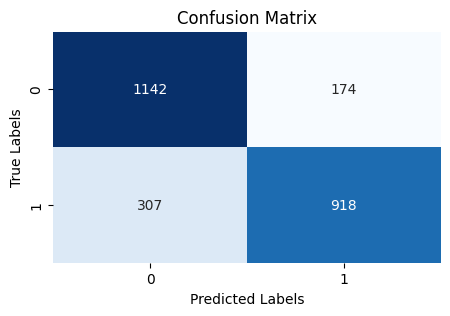

In [68]:
# Assign
cm = confusion_matrix(y_test, y_pred)


# Plotting the heatmap
plt.figure(figsize=(5, 3))  # Adjust size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  # 'fmt' is a string format code
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [66]:
# Get feature importances from the trained model
importances = clf.feature_importances_

# Get feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Define the number of top features you want to display
K = 20

# Get the indices of the K most important features in descending order of importance
indices = importances.argsort()[-K:][::-1]

# Display the top K important features with their names and importance scores
top_features = [(feature_names[i], importances[i]) for i in indices]
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")


miR: 0.0135
expression: 0.0095
reticulum: 0.0064
assay: 0.0064
cells: 0.0060
YAP: 0.0058
endoplasmic: 0.0055
apoptosis: 0.0053
Hippo: 0.0052
ER: 0.0051
invasion: 0.0050
proliferation: 0.0049
cell: 0.0047
luciferase: 0.0046
stress: 0.0044
lines: 0.0040
Western: 0.0039
levels: 0.0039
blot: 0.0039
microRNA: 0.0035
